# Overview

This notebook consist of two parts; 1) a descriptive analysis and 2) a predictive analysis. The descriptive analysis aim to investigate how sellers land on the platform and what channels are more effective, while the predictive analysis aim the estimate which sellers the SDR/SR should prioritize in order to land on the platform. It is crucial for business to attract customers, in Olist's case sellers, which attract customers. Since Olist retain 15% of the order value, then if Olist wants to increase their revenue, they have to attract sellers which generate many orders and/or high valued orders.

# <font color='blue'>Setup 1</font>: Load Libraries

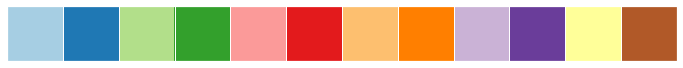

In [1]:
import numpy as np
import pandas as pd
import sys, os
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
sns.set()
sns.palplot(sns.color_palette("Paired"))
plt.rcParams['figure.figsize'] = (20.0, 6.0)
plt.style.use('ggplot')

# <font color='blue'>Setup 2</font>: Load data
The notebook will focus on the marketing funnel dataset. Therefore, only the following datasets are investigated:

- olist_marketing_qualified_leads_dataset
- olist_closed_deals_dataset

First, the olist_closed_deals_dataset is investigated solely and later the two datasets are joined by the left-join operation and dataformat is set. 

In [2]:
def load_table(tablename):
    """ Defining the current directory and path to where data are located. Joining path to
    data folder and table name in order to read the table into a Pandas DataFrame"""
    
    file_path = os.path.join ('../data/') 

    df = os.path.join(file_path, tablename) 
    df = pd.read_csv(df, sep=',', encoding="latin1") 
    
    return df

In [3]:
# Reading the olist_marketing_qualified_leads table
leads = load_table('olist_marketing_qualified_leads_dataset.csv')
#Reading the olist_closed_deals table
closed_leads = load_table('olist_closed_deals_dataset.csv')

# <font color='blue'>Setup 3</font>: Plotting functions
Some plotting function are defined to contribute the descriptive analysis with less coding and more describing text.

In [4]:
def land_page_map(df):
    land_page_dict = {}
    ID = 0
    for page in df['landing_page_id'].unique():
        land_page_dict[page] = ID
        ID += 1
        
    return land_page_dict

page_id_map = land_page_map(leads)

In [5]:
def create_mapping_column(df):
    plot_id = []
    for i in df['landing_page_id']:
        plot_id.append(page_id_map.get(i))
    
    return plot_id

In [6]:
def plot_timeline(df, pct = True, log = False, origin = True):
    sns.set_palette(sns.color_palette("Paired"))
    
    series = pd.DataFrame(df,columns = ['first_contact_date','origin'])
    series['freq'] = series.groupby(['first_contact_date','origin'])['first_contact_date'].transform('count')
    series = series.drop_duplicates()
    
    new = series["first_contact_date"].str.split("-", n = 2, expand = True)
    series['first_contact_month'] = new[0]+'-'+new[1]+'-'+'01'
    
    series = series.groupby(['first_contact_month','origin'])['freq'].agg('sum').reset_index()
    
    series['log_value'] = np.log(series['freq'])
    series['log2_value'] = np.log2(series['freq'])
    series['percentage'] = series['freq']/len(df)
    series['first_contact_month'] = pd.to_datetime(series.first_contact_month)
    
    if origin == True:
        
        if pct == True:
            plt.figure(figsize=(20,6))
            sns.lineplot(data=series,x='first_contact_month',y='percentage',hue='origin',err_style=None)
            plt.title('Frequency over time by type of media where the lead was aquired')
            plt.ylabel('Frequency (%)', fontsize=12)
            plt.xlabel('Date', fontsize=12)
            plt.show()
        
        else:
            if log == True:
                plt.figure(figsize=(20,6))
                sns.lineplot(data=series,x='first_contact_month',y='log_value',hue='origin',err_style=None)
                plt.title('Log value of frequency over time by type of media where the lead was aquired')
                plt.ylabel('Log value of frequency', fontsize=12)
                plt.xlabel('Date', fontsize=12)
                plt.show()
                
            else:
                plt.figure(figsize=(20,6))
                sns.lineplot(data=series,x='first_contact_month',y='freq',hue='origin',err_style=None)
                plt.title('Frequency over time by type of media where the lead was aquired')
                plt.ylabel('Frequency', fontsize=12)
                plt.xlabel('Date', fontsize=12)
                plt.show()
    
    else:
        plt.figure(figsize=(20,6))
        sns.lineplot(data=series,x='first_contact_month',y='freq',err_style=None)
        plt.title('Frequency over time where the lead was aquired')
        plt.ylabel('Frequency', fontsize=12)
        plt.xlabel('Date', fontsize=12)
        plt.show()     
        

In [7]:
def plot_origin(df, year=True):
    sns.set_palette(sns.color_palette("Paired"))
    
    series = pd.DataFrame(df,columns = ['first_contact_date','origin'])
    series['freq'] = series.groupby(['first_contact_date','origin'])['origin'].transform('count')
    series = series.drop_duplicates()
    
    new = series["first_contact_date"].str.split("-", n = 2, expand = True)
    series['first_contact_year'] = new[0]
    
    series = series.groupby(['first_contact_year','origin'])['freq'].agg('sum').reset_index()
    series['percentage'] = round(series['freq']/len(df),2)
    
    if year==True:
        plt.figure(figsize=(20,6))
        sns.barplot(data=series, x='origin',y='percentage' , alpha=0.8, hue='first_contact_year')
        plt.title('Frequency by year of the type of media where the lead was aquired')
        plt.ylabel('Frequency (%)', fontsize=12)
        plt.xlabel('Origin', fontsize=12)
        plt.show()
    else:
        plt.figure(figsize=(20,6))
        sns.barplot(data=series, x='origin',y='percentage' , alpha=0.8)
        plt.title('Frequency of the type of media where the lead was aquired')
        plt.ylabel('Frequency (%)', fontsize=12)
        plt.xlabel('Origin', fontsize=12)
        plt.show()

In [8]:
def plot_top_n_land_page(df, n):
    sns.set_palette(sns.color_palette("Paired"))
    
    series = pd.DataFrame(df,columns = ['landing_page_id'])
    series['plot_id'] = create_mapping_column(df)
    
    series['freq'] = series['plot_id'].map(series['plot_id'].value_counts())
    series = series.groupby(['landing_page_id','plot_id'])['freq'].agg('max').reset_index()
    series = series.sort_values(by=['freq'],ascending=False)
    series['percentage'] = round(series['freq']/len(df),2)
    page_count = series[:n]
    
    plt.figure(figsize=(20,6))
    sns.barplot(data=page_count, x='plot_id', y='percentage', order=page_count['plot_id'], alpha=0.8)
    plt.title('Top 10 frequency of landing page id where the lead was aquired')
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.xlabel('Landing page id', fontsize=12)
    plt.show()
    
    print(page_count)

In [9]:
def plot_closed_vs_not(df1, df2):
    sns.set_palette(sns.color_palette("Paired"))
    
    series = pd.DataFrame(df1,columns = ['mql_id','origin'])
    ids = [x for x in df2.mql_id]
    series['closed'] = ['Closed' if x in ids else 'Not closed' for x in series.mql_id]
    series['freq'] = series.groupby(['origin','closed'])['origin'].transform('count')
    series = series.drop_duplicates()
    
    series = series.groupby(['origin','closed'])['freq'].agg('max').reset_index()
    series['percentage'] = np.where(series['closed']=='Not closed', round(series['freq']/len(df1),2), round(series['freq']/len(df2),2))
    
    plt.figure(figsize=(20,6))
    sns.barplot(data=series, x='origin',y='percentage', hue='closed', alpha=0.8)
    plt.title('Closed vs Not closed by the type of media where the lead was aquired')
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.xlabel('Origin', fontsize=12)
    plt.show() 

# <font color='blue'>Part 1</font>: Descriptive analysis

In terms of providing some context, the following discription is taken from the documentation:
> A seller join Olist through a marketing and sales funnel that was made public at this dataset. Description of steps:
1. After a lead fills in a form at a landing page, a filter is made to select the ones that are qualified to sell their products at Olist. They are the Marketing Qualified Leads (MQLs).
2. Then the Marketing Qualified Leads (MQLs) is contacted by a Sales Development Representative. (SDR), confirm some information and schedule a consultancy.
3. Consultancy is made by a Sales Representative (SR). The SR may close the deal (lead sing up) or lose the deal (led leaves without sign in)
4. Lead becomes a seller and starts building his catalog on Olist. His products are published on marketplaces and ready to sell!

To investigate how sellers land on the platform and what channels are more effective we want to answer the following questions:

1. How does the number of marketing qualified leads move over time?
2. Which landing pages brings in most qualified leads?
3. Which of the landing pages is most effective? 
4. Which media types does the closed leads origin from? and which ones are most effective?
5. How long time is the average closing? 
6. Are there periods where it seems more appropriate to contact the leads than others?
7. How many customers does already have a declaired revenue? And what type of business are they? 
8. Which SDR/SR is best at talking to different business segments?

## <font color='blue'>1.1</font>:  How does the number of marketing qualified leads move over time?

In [10]:
leads.describe()

,mql_id,first_contact_date,landing_page_id,origin
count,8000,8000,8000,7940
unique,8000,336,495,10
top,80bd1978a3dff0dbaceb95fb9191e7ee,2018-05-02,b76ef37428e6799c421989521c0e5077,organic_search
freq,1,93,912,2296


In the olist marketing qualified leads dataset we find 8.000 unique marketing qualified leads. Those 8.000 leads was acquired on 495 unique landing pages spread out on 336 unique contact dates. The landing pages can be categorised into 10 types of media where the lead was acquired. The first lead was acquired 06-14-2017 and the latest 05-31-2018.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


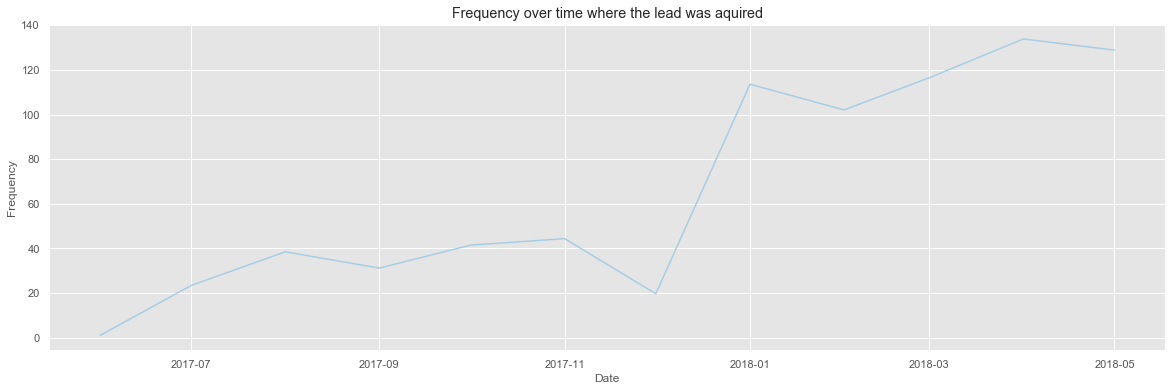

In [11]:
plot_timeline(leads, pct = False, log = False, origin = False)

Between November 2017 and January 2018 we see a significant rise in acquired marketing qualified leads. 

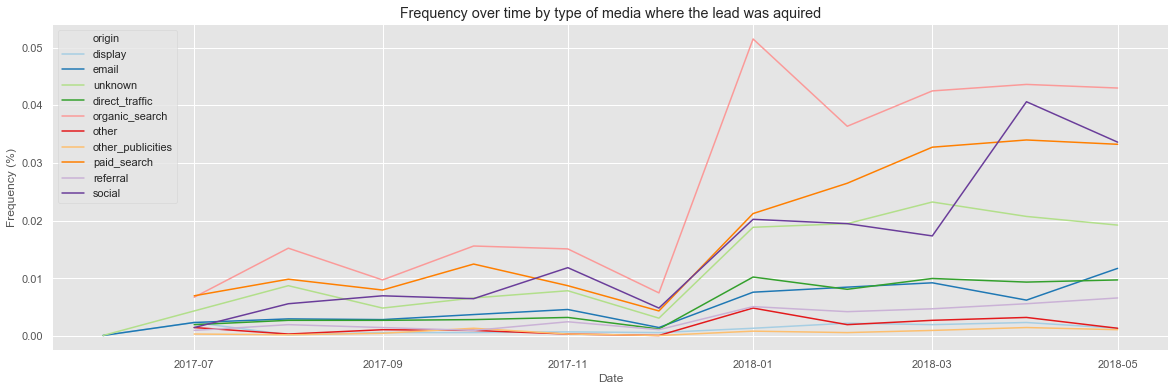

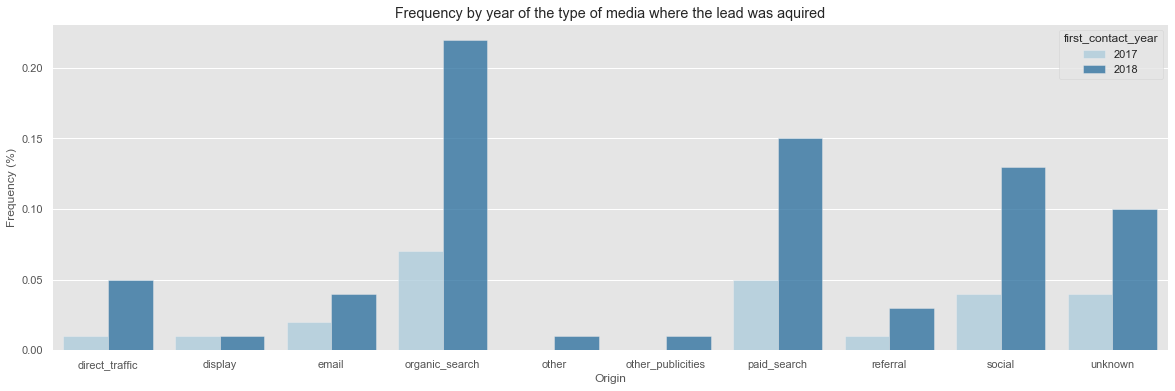

In [12]:
plot_timeline(leads, pct = True, log = False, origin = True)
plot_origin(leads, year=True)

This increase is primarily attributable to the use of the media types `organic_search`, `paid_search` and `social`.

## <font color='blue'>1.2</font>:  Which landing pages brings in most qualified leads?

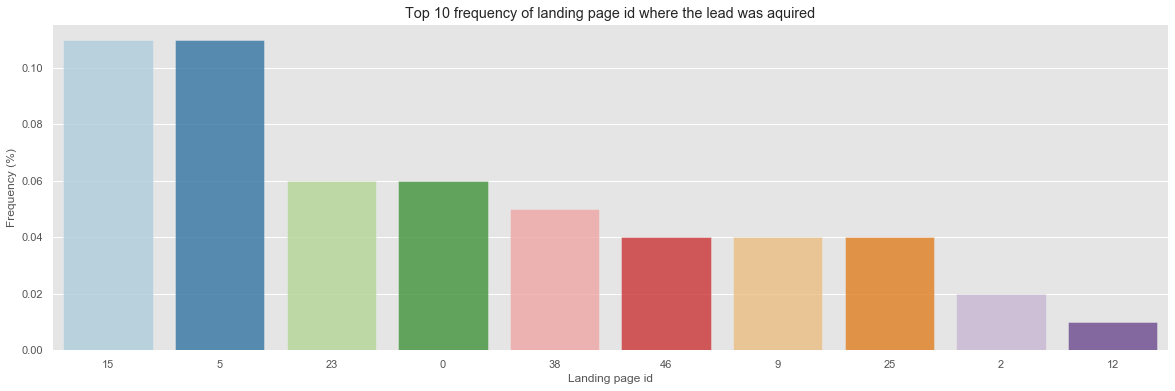

                      landing_page_id  plot_id  freq  percentage
356  b76ef37428e6799c421989521c0e5077       15   912        0.11
61   22c29808c4f815213303f8933030604c        5   883        0.11
159  58326e62183c14b0c03085c33b9fdc44       23   495        0.06
262  88740e65d5d6b056e0cda098e1ea6313        0   445        0.06
394  ce1a65abd0973638f1c887a6efcfa82d       38   394        0.05
122  40dec9f3d5259a3d2dbcdab2114fae47       46   330        0.04
468  f017be4dbf86243af5c1ebed0cff36a2        9   310        0.04
443  e492ee5eaf1697716985cc6f33f9cd9b       25   291        0.04
321  a7982125ff7aa3b2054c6e44f9d28522        2   156        0.02
228  73f31a40697cc90a86c1273563ac230e       12   115        0.01


In [13]:
plot_top_n_land_page(leads,10)

Over 20% of the marketing qualified leads are acquired through the landing pages *b76ef37428e6799c421989521c0e5077* and *22c29808c4f815213303f8933030604c*

## <font color='blue'>1.3</font>: Which of the landing pages is most effective? 
The olist_marketing_qualified_leads_dataset is now joined with the olist_closed_deals_dataset. The two datasets are merged, so we can obtain insights on the closed deals and compare with the total qualified marketing leads. 

In [14]:
closed_leads = closed_leads.merge(leads, on="mql_id", how= "left")
closed_leads.describe(include=['O'])

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,first_contact_date,landing_page_id,origin
count,842,842,842,842,842,841,836,665,63,64,66,832,842,842,828
unique,842,842,32,22,824,33,8,9,2,2,6,3,195,134,10
top,b9ed46d1ff01c4fb8e3f2453091804d0,b1116e9a35b2fa91eb4a0af8e73cdc3a,4b339f9567d060bcea4f5136b9f5949e,4ef15afb4b2723d8f3d81e51ec7afefe,2018-05-04 03:00:00,home_decor,online_medium,cat,True,True,5-20,reseller,2018-02-06,22c29808c4f815213303f8933030604c,organic_search
freq,1,1,140,133,6,105,332,407,58,54,22,587,14,174,271


In the joined dataset we find 842 unique closed leads. I.e. out of the 8.000 marketing qualified leads only ~10% was closed. The 842 closed leads was contacted by one of 32 sales development representatives (SDR), while the consultancy was provided by 22 different sales representatives (SR). The `sellers` are categorised into 33 different `business_segment`, 3 `business_type`, 8 `lead_type` and 9 `lead_behaviour_profile`. Furthermore, an `average_stock`, `declared_product_catalog_size` and `declared_monthly_revenue` is occasionally noted. The first lead was closed 12-05-2017 and the latest 11-14-2018.

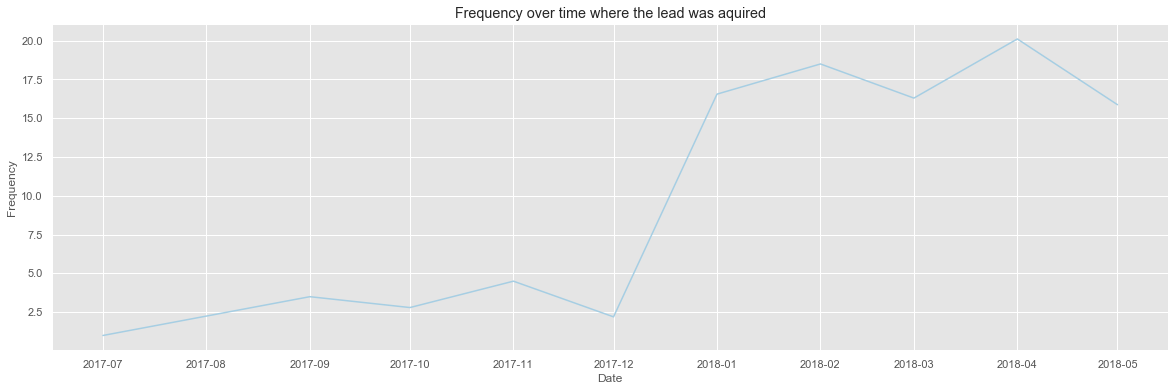

In [15]:
plot_timeline(closed_leads, pct = False, log = False, origin = False)

Between November 2017 and January 2018 we see the same significant rise in acquired marketing qualified leads. 

## <font color='blue'>1.4</font>: Which media types does the closed leads origin from? and which ones are most effective?

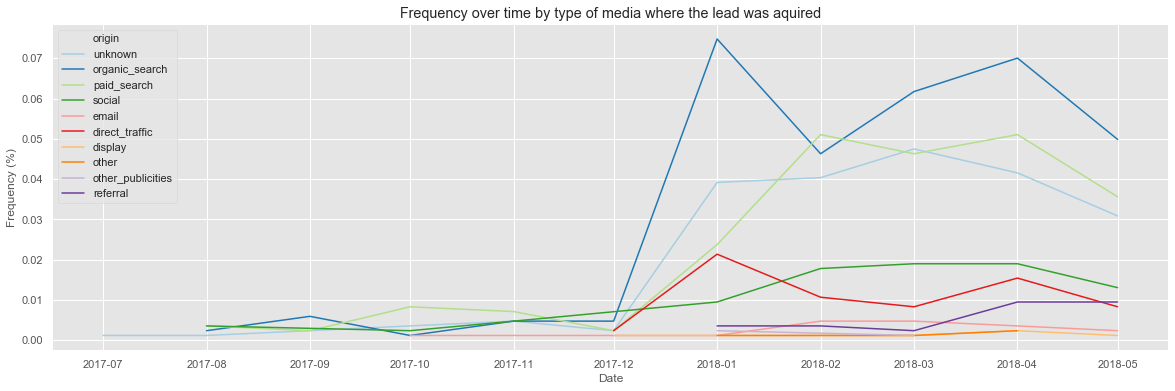

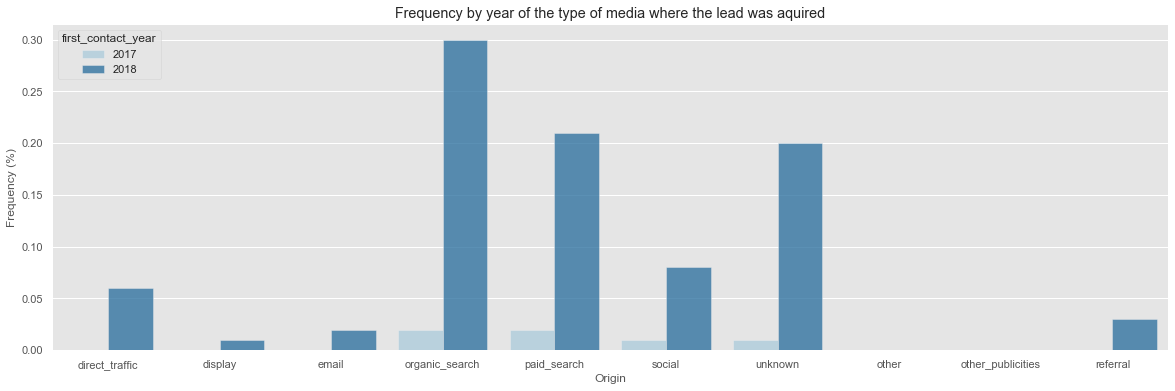

In [16]:
plot_timeline(closed_leads, pct = True, log = False, origin = True)
plot_origin(closed_leads, year=True)

This increase is again primarily attributable to the use of the media types `organic_search`, `paid_search` and `social`.

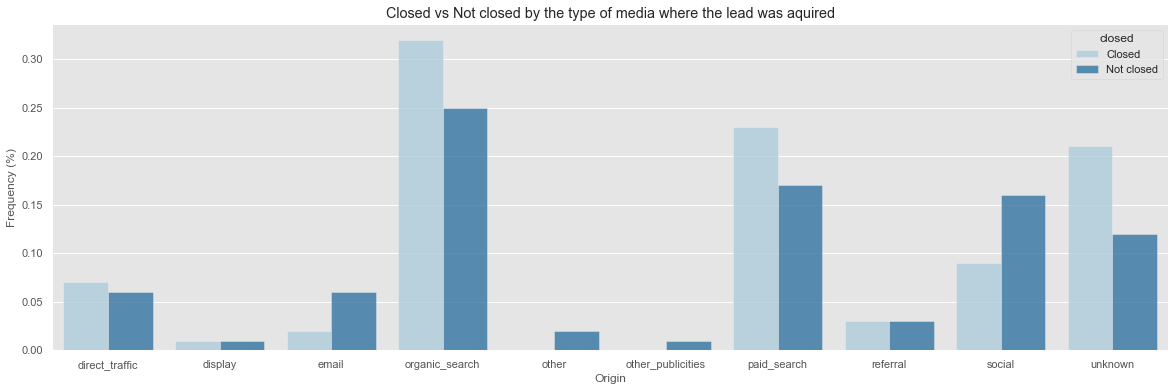

In [17]:
plot_closed_vs_not(leads, closed_leads)

But this time we see that `organic_search` and `paid_search` is much more effect. Their importance is respectively ~6 and ~7 percentage point more significant.

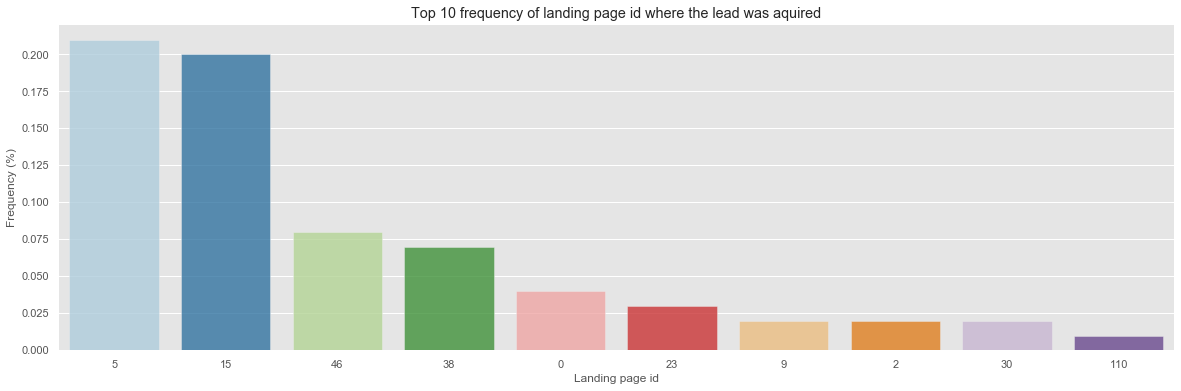

                      landing_page_id  plot_id  freq  percentage
23   22c29808c4f815213303f8933030604c        5   174        0.21
95   b76ef37428e6799c421989521c0e5077       15   171        0.20
44   40dec9f3d5259a3d2dbcdab2114fae47       46    67        0.08
106  ce1a65abd0973638f1c887a6efcfa82d       38    59        0.07
77   88740e65d5d6b056e0cda098e1ea6313        0    31        0.04
50   58326e62183c14b0c03085c33b9fdc44       23    27        0.03
126  f017be4dbf86243af5c1ebed0cff36a2        9    21        0.02
86   a7982125ff7aa3b2054c6e44f9d28522        2    18        0.02
24   241f79c7a8fe0270f4fb79fcbbcd17ad       30    14        0.02
68   7fa6214d82e911d070f51ef79381b956      110    11        0.01


In [18]:
plot_top_n_land_page(closed_leads,10)

This time over 40% of the closed marketing qualified leads are acquired through the landing pages *b76ef37428e6799c421989521c0e5077* and *22c29808c4f815213303f8933030604c*

## <font color='blue'>1.5</font>:  How long is the average period for closing a seller?

In [19]:
#Changing these columns to datetimes
closed_leads.first_contact_date = pd.to_datetime(closed_leads.first_contact_date)
closed_leads.won_date = pd.to_datetime(closed_leads.won_date)

In [20]:
#Making an overview of the period from initial contact to closed deal
closed_leads["closing_period"] = closed_leads.won_date-closed_leads.first_contact_date

#Assessing the result from the operation. 
closed_leads.closing_period.head()

0     5 days 19:58:54
1    34 days 20:17:59
2    63 days 17:27:23
3     3 days 13:51:03
4   267 days 20:17:45
Name: closing_period, dtype: timedelta64[ns]

Since a closing period can't be negative, we check if the feature extraction is done correctly.

In [21]:
closed_leads[closed_leads.closing_period.values/np.timedelta64(1, 'D')<0]

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,first_contact_date,landing_page_id,origin,closing_period
667,b91cf8812365f50ff4bda4bcd6206b05,5e063e85d44b0f5c3e6ec3131103a57e,a8387c01a09e99ce014107505b92388c,495d4e95a8cf8bbf8b432b612a2aa328,2018-03-06 19:38:55,health_beauty,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-03-08,4aab772aeb9833c170d8ea5413e02eac,organic_search,-2 days +19:38:55


The feature extraction seems to been done correctly. However, one observation contains an impossible `won_date`. Therefor we choose to remove this observation from our dataset.

In [22]:
closed_leads = closed_leads.drop(667)

Since we have now obtained the time difference from when the initial contact was made until the closing, we are now able to use this datastrucutre to plot the distribution. 

In [23]:
#Example od a datastructure:
print("This is how the data is formatted: ",closed_leads.closing_period[0])
print("This is the period plotted: ", closed_leads.closing_period.values[0]/np.timedelta64(1, 'D'))

This is how the data is formatted:  5 days 19:58:54
This is the period plotted:  5.832569444444444


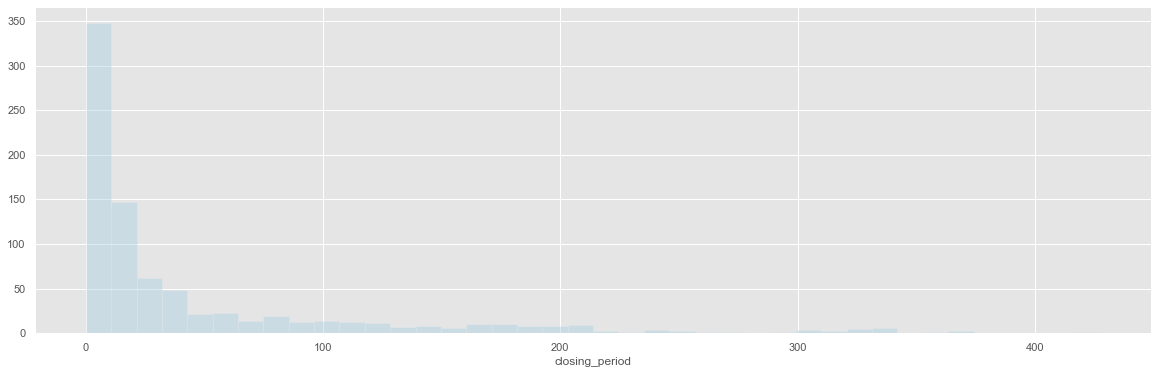

In [24]:
plt.figure(figsize=(20,6))
sns.distplot(closed_leads.closing_period/np.timedelta64(1, 'D'),bins=40, kde = False);

## <font color='blue'>1.6</font>:  Are there periods where it seems more appropriate to contact the leads than others? 

This question is answered by looking at the leads dataset in comparison with all the closed sellers

In [25]:
#First, the format of the first_contact_date column in the lead dataset is also transformed into datetimes
leads.first_contact_date = pd.to_datetime(leads.first_contact_date)

#In both datasets, we are making a distinct column which holds the month where the seller was contacted
closed_leads["Month_contacted"] = closed_leads.first_contact_date.dt.month
leads["month_contacted"] = leads.first_contact_date.dt.month

#Then we make a variable which hold the data to be plotted:
pct_closed_per_month = closed_leads.groupby(closed_leads["first_contact_date"].dt.month).count().Month_contacted/len(closed_leads)
pct_leads_per_month = leads.groupby(leads["first_contact_date"].dt.month).count().month_contacted/len(leads)

#And put these new variables into a dataframe, so that we can plot these two columns together in the same barchart
months_overview = pd.DataFrame(pct_closed_per_month)
months_overview.columns=["Closed leads contacted"]
months_overview["Leads contacted"] = pct_leads_per_month

In [26]:
months_overview

,Closed leads contacted,Leads contacted
first_contact_date,,
1,0.180737,0.142625
2,0.177170,0.128500
3,0.197384,0.146750
4,0.217598,0.169000
5,0.154578,0.162875
7,0.002378,0.029875
8,0.010702,0.048250
9,0.008323,0.039000
10,0.016647,0.052000


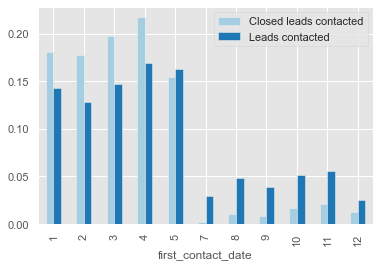

In [27]:
months_overview.plot.bar();

## <font color='blue'>1.7</font>:  How many customers does already have a declaired revenue? And what type of business are they?

In [28]:
print("The number of closed companies are: ", len(closed_leads), "\n", \
      "Of all the closed leads the following amount already had a declaired revenue: ", len(closed_leads[closed_leads.declared_monthly_revenue>0]), "\n", \
     "Which amounts to ", len(closed_leads[closed_leads.declared_monthly_revenue>0])/len(closed_leads)*100,"% of the total closed leads")

The number of closed companies are:  841 
 Of all the closed leads the following amount already had a declaired revenue:  45 
 Which amounts to  5.35077288941736 % of the total closed leads


##### The total distribution and exploration of the lead type, business type and business segment

In [29]:
#Defining a pandas with only relevant metrics
business_types = closed_leads[["business_segment", "lead_type", "business_type"]]

In [30]:
#Assessing whether they hold nan values (some of them does)
business_types.isnull().sum()

business_segment     1
lead_type            6
business_type       10
dtype: int64

In [31]:
segment = business_types.business_segment.value_counts()
l_type = business_types.lead_type.value_counts()
b_type = business_types.business_type.value_counts()

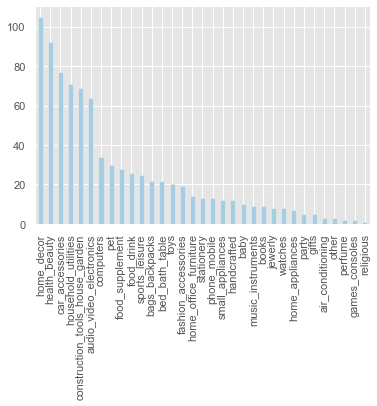

In [32]:
segment.plot.bar();

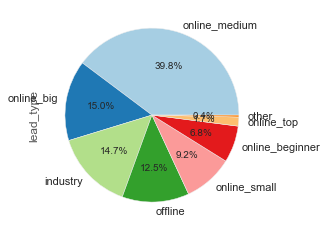

In [33]:
l_type.plot.pie(title=None, autopct='%1.1f%%');

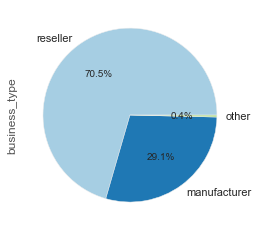

In [34]:
b_type.plot.pie(autopct='%1.1f%%');

## <font color='blue'>1.8</font>:  Which SDR/SR is best at talking to different business segments?

A Sales Development Representative is one having the initial contact witht the company, right after the company has signed up on the landing page. The SDR is noting some general information and arranging a meeting for when the business can meet a Sales Representative who may win or lose the deal.

In general, it is quite difficult to say whether a SR and SDR is good, relative to how many deals they did not close. However, since the SR's and SDR's are not present in the MQL dataset, it is not possible to measure their actual performance agains the number of lost deals. 
Therefore, we assume they have a steady stream of contact with potential sellers, and that some SR's and SDR's are just better at closing the sellers than other SR's and SDR's. 

The following distributions of the rate of closed customers can then be used to address how potentially high value sellers should be contacted and **by who**. 

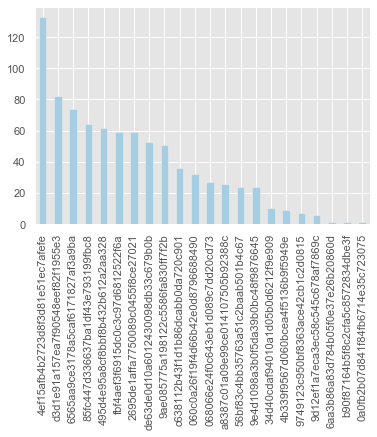

In [35]:
closed_leads.sr_id.value_counts().plot.bar();

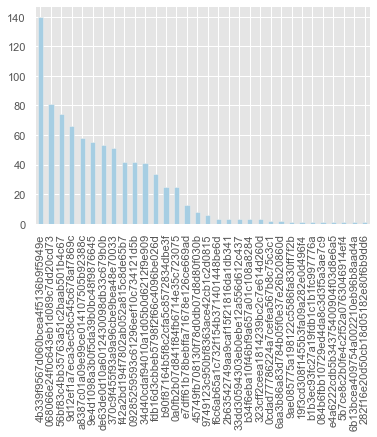

In [36]:
closed_leads.sdr_id.value_counts().plot.bar();

##### Looking at every individual SR and what sellers they are closing in terms of business segments and lead type

In [37]:
#Creating a dataframe holding the different business segments
df_seg = closed_leads.groupby(["sr_id","business_segment"]).count().seller_id.reset_index(name="count")

In [38]:
#Ordering the data properly and removing nan values
df_seg = df_seg.pivot(index= "sr_id", columns= "business_segment", values= "count")
df_seg = df_seg.fillna(0)

In [39]:
#Creating a total column to order the data for later plotting. After ordering, the total column is dropped
df_seg["total"] = df_seg.sum(axis=1)
df_seg = df_seg.sort_values("total",ascending= True)
df_seg = df_seg.drop(["total"],axis=1)

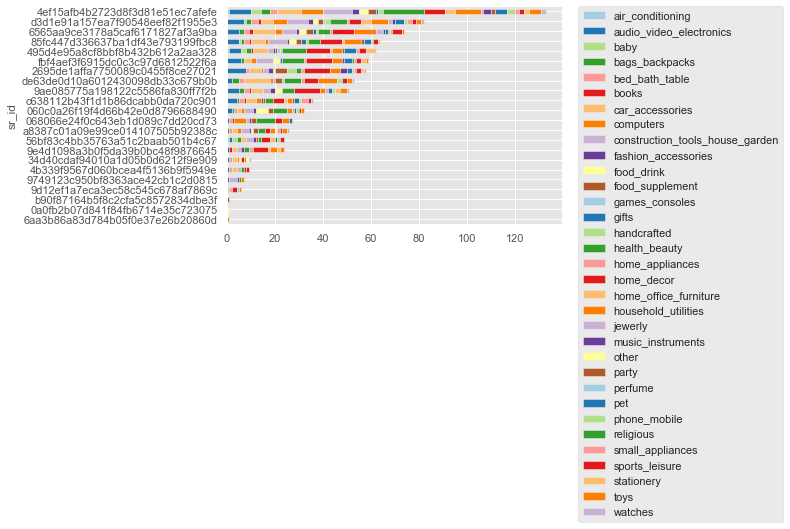

In [40]:
df_seg.plot.barh(stacked= True).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

In [41]:
#Same procedure with lead type:
df_lead = closed_leads.groupby(["sr_id","lead_type"]).count().seller_id.reset_index(name="count")

df_lead = df_lead.pivot(index= "sr_id", columns= "lead_type", values= "count")
df_lead = df_lead.fillna(0)

df_lead["total"] = df_lead.sum(axis=1)
df_lead = df_lead.sort_values("total",ascending= True)
df_lead = df_lead.drop(["total"],axis=1)

In [42]:
plt.style.use(['seaborn-whitegrid'])
sns.set_palette("cubehelix",10)

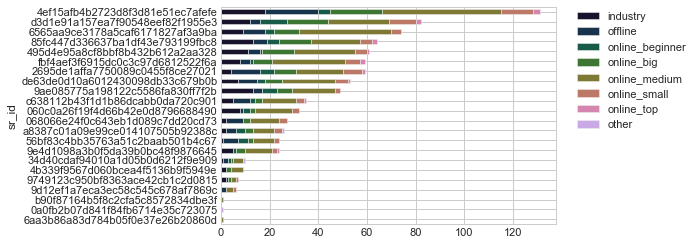

In [43]:
df_lead.plot.barh(stacked= True).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

The plot proves a very important point, namely that the different SR's does not get specific business segments, which could potentially be easier to close. However, they are all recieving a variety of different segments and lead types, which indicate that some SR's are just inherintly better at closing the sellers. 

##### Look at the landing page in combination with origin. This way we can make some kind of probability for closing the customer, from the data we have available - since this is the only features that both datasets have in common. 

# !!!! see above !!!!

## <font color='blue'>1.9</font>:  Conclusion on the descriptive analysis

The descriptive analysis tells us:
- From 2017 to 2018 we have a significant rise in leads and therefor also a significant rise in closed leads. Though, the significant rise is not due to a more effective process, rather because more leads fill in the forms on the landing pages.
- We see two landing pages holding ~50% of the closed deals out of a total of 495 landing pages.
- ~60% of the leads lands on the platform through ´origin_search´, ´paid_search´ and ´social_media´, where respectively 32%, 23% and 9% of them are closed. I.e. our most effective media channels are by far ´origin_search´ and ´paid_search´.
- SDR/SR don't get marketing qualified leads from a specific business segments. I.e. we don't get specialized in dealing with a specific type of seller.

## <font color='blue'>Part 2</font>: Predictive analysis - which sellers should be prioritized?

## <font color='blue'>2.1</font>:  Missing values

Missing values can cause errors in algorithms and real world data often has missing values.

First of all, there is no "good-way" to handle missing values. But in general there is three methods to handle missing values.

1. Remove rows or columns containing missing values
    - This is the simplest method for handling missing values. 
        - Pro's: easy too handle and doesn't add noise to data. 
        - Con's: can be too limiting for some datasets, i.e. removing too much information.
        
2. Impute missing values
    - Refers to the act of replacing the missing values with the mean, median, mode, a constant etc.
        - Pro's: we keep information, though adding some noise.
        - Con's: maybe missing values have a meaning?
        
3. Predict missing values
    - Refers to the act of imputing missing values by using a prediction rule .
        - Pro's: we keep information and approximates the missing values to the "true" information.
        - Con's: maybe missing values have meaning and the approximated "true" information get too biased.


In order to choose a meaningful approach, we need to get an overview of the missing values.

In [44]:
def count_missing_values(df):
    missing = df.isna()
    num_missing = pd.DataFrame(missing.sum(),columns=['Number'])
    num_missing['Percentage'] = round(num_missing / len(df),2)
    
    print(num_missing)

In [45]:
show_nans= lambda df: df[df.isnull().any(axis=1)]

In [46]:
count_missing_values(closed_leads)

                               Number  Percentage
mql_id                              0        0.00
seller_id                           0        0.00
sdr_id                              0        0.00
sr_id                               0        0.00
won_date                            0        0.00
business_segment                    1        0.00
lead_type                           6        0.01
lead_behaviour_profile            177        0.21
has_company                       778        0.93
has_gtin                          777        0.92
average_stock                     775        0.92
business_type                      10        0.01
declared_product_catalog_size     772        0.92
declared_monthly_revenue            0        0.00
first_contact_date                  0        0.00
landing_page_id                     0        0.00
origin                             14        0.02
closing_period                      0        0.00
Month_contacted                     0        0.00


If the column contains 85% missing values then we choose to drop the column. Meaning we are dropping the columns `has_company`, `has_gtin`, `average_stock` and `declared_product_catalog_size`.

In [47]:
closed_leads = closed_leads.drop(['has_company'], axis=1)
closed_leads = closed_leads.drop(['has_gtin'], axis=1)
closed_leads = closed_leads.drop(['average_stock'], axis=1)
closed_leads = closed_leads.drop(['declared_product_catalog_size'], axis=1)

In [48]:
count_missing_values(closed_leads)

                          Number  Percentage
mql_id                         0        0.00
seller_id                      0        0.00
sdr_id                         0        0.00
sr_id                          0        0.00
won_date                       0        0.00
business_segment               1        0.00
lead_type                      6        0.01
lead_behaviour_profile       177        0.21
business_type                 10        0.01
declared_monthly_revenue       0        0.00
first_contact_date             0        0.00
landing_page_id                0        0.00
origin                        14        0.02
closing_period                 0        0.00
Month_contacted                0        0.00


Regarding the coloumns `lead_behaviour_profile`, `business_segment`, `lead_type`, `business_type` and `origin`  we have a total of 308 missing values. Since we are not interested in dropping neither the columns or 36% of our observations, we choose to replace missing values with the their respectively category for *unknown* observations. I.e. we interpret the missing values of being either an *unknown* or *other* observation.

In [49]:
closed_leads['lead_behaviour_profile'] = closed_leads['lead_behaviour_profile'].fillna('unknown')
closed_leads['origin'] = closed_leads['origin'].fillna('unknown')
closed_leads['business_segment'] = closed_leads['business_segment'].fillna('other')
closed_leads['lead_type'] = closed_leads['lead_type'].fillna('other')
closed_leads['business_type'] = closed_leads['business_type'].fillna('other')

In [50]:
show_nans(closed_leads)

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue,first_contact_date,landing_page_id,origin,closing_period,Month_contacted


In [51]:
count_missing_values(closed_leads)

                          Number  Percentage
mql_id                         0         0.0
seller_id                      0         0.0
sdr_id                         0         0.0
sr_id                          0         0.0
won_date                       0         0.0
business_segment               0         0.0
lead_type                      0         0.0
lead_behaviour_profile         0         0.0
business_type                  0         0.0
declared_monthly_revenue       0         0.0
first_contact_date             0         0.0
landing_page_id                0         0.0
origin                         0         0.0
closing_period                 0         0.0
Month_contacted                0         0.0


## <font color='blue'>2.2</font>: Feature extraction

### Assumption: 
As mentioned in the beginning of the notebook, we assume that *Olist retain 15% of the order value.*

**Therefor, a profitable seller is generating many orders or/and high valued orders.**

        We create a prediction rule to tell a sellers weekly average turnover.

In order to extract the target variable *weekly average turnover*, we merge the olist_closed_deals_dataset with the olist_order_items_dataset. But first, we need to calculate the *weekly average turnover*. This is done in the olist_order_items_dataset before merging. To do the calculation we also need a variable telling how many days a seller has been active on the platform. We call this variable *time_as_seller*.

In [52]:
all_orders = load_table("olist_order_items_dataset.csv")
all_orders.describe(include='O')

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2018-03-01 02:50:48
freq,21,527,2033,21


In [53]:
print(np.round((1-(98666/112650))*100,2),'% of the orders includes more than 1 item')

12.41 % of the orders includes more than 1 item


Thus, we need to make an aggregation of the order price grouped by both the order id and seller id. In this way we ensure that the calculations can handle orders including multiple products and multiple sellers. We do the calculation seperately from the all_orders dataframe and instead call it total_revenue.

In [54]:
order_items = load_table("olist_order_items_dataset.csv")
order_items_filt = order_items.groupby(['order_id', 'product_id','seller_id','shipping_limit_date','price'])['order_item_id'].agg({"quantity":"max"}).reset_index()
order_items_filt['order_price'] = order_items_filt['price']*order_items_filt['quantity']
total_revenue = order_items_filt.groupby(['seller_id'])['order_price'].agg('sum').reset_index()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


Then we estimate the time a seller has been active on the platform and call variable *time_as_seller*. As we want to extract the *weekly average turnover*, a new variable is made by dividing the *time_as_seller* with 7. We call this variable *weeks_as_seller*.

In [55]:
all_orders['shipping_limit_date'] = pd.to_datetime(all_orders['shipping_limit_date'])
all_orders['time_as_seller'] = all_orders['shipping_limit_date'].max() - all_orders['shipping_limit_date']
all_orders['weeks_as_seller'] = all_orders['time_as_seller'].dt.days/7

Since *weeks_as_seller* is defined by the last registrated shipment, we need to find the max value of this variable.

In [56]:
all_orders = all_orders.groupby(['seller_id'])['weeks_as_seller'].agg('max').reset_index()

Then we merge the total_revenue dataframe and the all_orders dataframe and get a new dataframe called sellers. This dataframe has the seller id as primary key and includes their total revenue and the total days active on the platform. Thus, we can calculate the target variable *weekly average turnover*.

In [57]:
sellers = all_orders.merge(total_revenue, on="seller_id", how= "left")
sellers['weekly_avg_revenue']=sellers.order_price/sellers.weeks_as_seller
sellers.describe()

,weeks_as_seller,order_price,weekly_avg_revenue
count,3095.000000,3095.000000,3095.000000
mean,127.825987,4526.500514,31.873235
std,28.362946,14364.843840,93.683017
min,83.428571,3.500000,0.023048
25%,102.000000,219.410000,1.912564
50%,125.857143,847.350000,7.133456
75%,153.357143,3403.995000,25.111616
max,185.428571,232542.720000,1639.781651


We can now join our two extracted features with the olist_closed_deals_dataset. This in done on the seller id with a inner join.

In [58]:
data = closed_leads.merge(sellers, on='seller_id', how="inner")
data = data.drop(['weeks_as_seller','order_price','sdr_id','sr_id','won_date',
      'first_contact_date','landing_page_id','closing_period'],axis=1)

In [59]:
data.describe(include='O')

,mql_id,seller_id,business_segment,lead_type,lead_behaviour_profile,business_type,origin
count,379,379,379,379,379,379,379
unique,379,379,29,8,7,3,9
top,a0ab09eb2842e474a3a5aed12e533a2a,aae5e7b457a3c72ee230a47d98fceda5,home_decor,online_medium,cat,reseller,organic_search
freq,1,1,44,172,183,286,112


The inner join resulted in a 55% data reduction. I.e. we were only able to calculate a weekly_avg_revenue for 45% of the sellers in the olist_closed_deals_dataset.

But we can now plot the weekly average revenue for the 379 closed qualified marketing leads by the media type they originated from. 

In [60]:
def plot_weekly_revenue(df):
    plot_data = df.groupby('origin')['weekly_avg_revenue'].agg('mean').reset_index()
    freq = df.groupby('origin')['mql_id'].agg('count').reset_index()
    plot_data['freq'] = freq.mql_id
    
    plt.bar(plot_data.origin, plot_data.freq, color='lightblue')
    plt.ylabel('Frequency')      

    axes2 = plt.twinx()
    axes2.plot(plot_data.origin, plot_data.weekly_avg_revenue, color='red', label='Avg. weekly revenue')
    axes2.set_ylabel('Avg. weekly revenue')
    
    plt.axhline(plot_data['weekly_avg_revenue'].mean(), color='black', linestyle='dashed', linewidth=1)
    
    plt.title('Number of closed leads and their avg. weekly revenue by origin')
    plt.show()

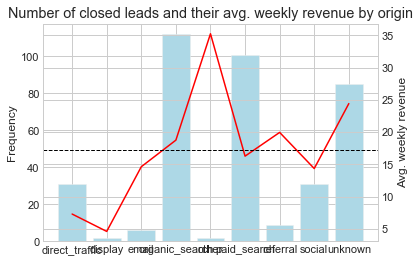

In [61]:
plot_weekly_revenue(data)

Here we see that the sellers with the highest average weekly revenue originates from the media types organic_search, paid_search and the unknown category.

## <font color='blue'>2.3</font>: Prediction model
Unfortunately, we aren’t quite ready to feed the raw data into a prediction model. First, we are required to convert any categorical variable to a numeric representation. There are basically two methods to do this: 

1. Label Encoder
    - A label encoder encodes labels with a value between 0 and n_classes-1 where n is the number of distinct labels. 
        - pros: Keep the dimensionality to a minimum.
        - cons: The model can misunderstand the data to be in a meaningful order, 0 < 1 < 2.

2. One-Hot Encoder
    - One-Hot encoder, takes a column which has categorical data and splits the column into multiple columns. The categorical data are replaced by 1's and 0's, depending on which observation has which category. 
        - pros: The model won't derive false correlations.
        - cons: The data becomes more sparse, the dimensionality increases and the computation therefor gets more expensive.

The categorial variables are converted into dummy/indicator variables using pandas get_dummies()-function. 
Furthermore, the correlation between the features and the target variables are shown in a list.

In [62]:
#convert categorical columns to numerical
df = pd.get_dummies(data, columns=['business_segment', 'lead_behaviour_profile', 
                                     'lead_type','business_type','origin'])

In [63]:
#calculate and show correlations
corr_matrix = df.corr()
corr_matrix['weekly_avg_revenue'].sort_values(ascending=False)

weekly_avg_revenue                                  1.000000
business_segment_watches                            0.474464
lead_type_other                                     0.167392
lead_type_online_big                                0.149175
business_segment_small_appliances                   0.097318
lead_behaviour_profile_shark                        0.092857
business_type_reseller                              0.084449
business_segment_home_appliances                    0.068019
origin_unknown                                      0.054146
lead_behaviour_profile_unknown                      0.051647
business_segment_home_office_furniture              0.021740
business_segment_pet                                0.021262
business_segment_health_beauty                      0.020987
origin_other                                        0.019785
business_segment_baby                               0.018627
origin_organic_search                               0.007289
origin_referral         

Before we fit the prediction model, our data is scaled using the MinMaxScaler from sklearn. After the data is splitted into a test and train set. 

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df.drop(['seller_id','mql_id','weekly_avg_revenue'],axis=1)
features = X.columns
y = df['weekly_avg_revenue']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [99]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (303, 58)
Training Labels Shape: (76, 58)
Testing Features Shape: (303,)
Testing Labels Shape: (76,)


In [100]:
print("{0:0.2f}% in training set".format((len(X_train)/len(data.index))*100))
print("{0:0.2f}% in test set".format((len(X_test)/len(data.index))*100))

79.95% in training set
20.05% in test set


In [119]:
def metrics(y, yhat):
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    
    mae = mean_absolute_error(y, yhat)
    
    print('Mean absolute error:', round(mae, 2), 'BRL.')

### Linear Regression (simple baseline)
Linear Regression is one of the simplest regression model. We use this model as a simple baseline model to establish our prediction rule.

In [120]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [121]:
lr_model_train = lr_model.predict(X_train)
print("Training accuracy:")
metrics(y_train, lr_model_train)

Mean absolute error: 17.87 BRL.


In [122]:
lr_predict_test = lr_model.predict(X_test)
print("Test accuracy:")
metrics(y_test, lr_predict_test)

Mean absolute error: 1638057968176.62 BRL.


With the Linear Regression model the average estimate is off by 1638057968176.62 BRL. But since the average estimate is only off by 17.87 BRL when predicted on the training data, it seems like the model is overfitting to the training data. This might be attributable to the limited set of data points or that the feature space doesn't explain the target variable well enough or the fact that most of our features doesn't have a linear shape.

### Random Forrest 
Because we are lacking features with a linear shape, we will instead try the Random Forrest model, which is a non-parametric model. Furthermore, it's less prone to overfitting, because it's a ensemble method, i.e. it takes the average of all the predictions, which cancels out the biases.

In [123]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=11, min_samples_split=2, random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=11,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [124]:
rf_predict_train = rf_model.predict(X_train)
print("Training accuracy:")
metrics(y_train, rf_predict_train)

Mean absolute error: 8.2 BRL.


In [125]:
rf_predict_test = rf_model.predict(X_test)
print("Test accuracy:")
metrics(y_test, rf_predict_test)

Test accuracy:
Mean absolute error: 39.76 BRL.


With the Random Forrest model the average estimate is off by 39.76 BRL. Which is an incredible improvement over the Linear Regression model.

Now we have experimented with both a parametric model and a non-parametric model. Random Forrest showed a much better performance telling us that our training data is not truly linear distributed. But we still se the Random Forrest model having a problem of generalizing well to the training data. This still might be attributable to the limited set of data points or that the feature space doesn't explain the target variable well enough. But it could also be attributable to the high dimensionality or the sparsity of our data. 

### Support Vector Machine
Because of the high dimensionality, we will instead try the Support Vector Machine (SVM) model.

In [128]:
from sklearn.svm import SVR
svr_model = SVR()
svr_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [129]:
svr_predict_train = svr_model.predict(X_train)
print("Training accuracy:")
metrics(y_train, svr_predict_train)

Training accuracy:
Mean absolute error: 17.14 BRL.


In [130]:
svr_predict_test = svr_model.predict(X_test)
print("Test accuracy:")
metrics(y_test, svr_predict_test)

Test accuracy:
Mean absolute error: 9.77 BRL.


With the Support Vector Machine model the average estimate is off by 9.77 BRL. Which again is an incredible improvement over the Random Forrest model.

## <font color='blue'>2.4</font>: Side note

One of the advantages of the random forrest model is, that is produces a overall feature importance, i.e. a indication of how well a given feauture explains the target variable. This call for some explenation. In short, the random forrest model works by dividing the data into subsets. The random forrest will continue to extract different subsets of data until it understands the relations between the features and the target variable. Thus, the random forrest model learns which split contributes most to predicting the target variable correctly. 

Therefor, the `sklearn` libraby has a function for the random forrest model called `feature_importances_`, which returns an array of each feature's importance in determining these splits. This importance indicates how well a features explains the target variable.

In [110]:
feature_imp = pd.Series(rf_model.feature_importances_,index=features).sort_values(ascending=False)
feature_imp[:10]

business_segment_watches            0.707201
business_segment_health_beauty      0.056308
lead_type_other                     0.041813
origin_paid_search                  0.025197
business_segment_home_appliances    0.023823
lead_behaviour_profile_shark        0.017654
lead_type_online_small              0.017128
lead_behaviour_profile_cat          0.015783
lead_type_online_big                0.015215
Month_contacted                     0.013113
dtype: float64

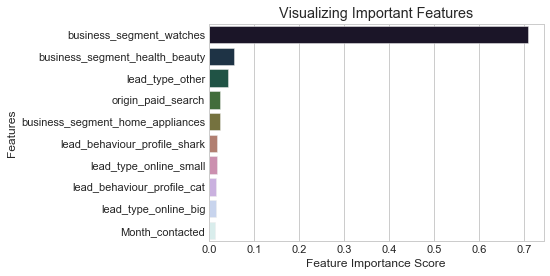

In [112]:
sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## <font color='blue'>2.5</font>: Conclusion

From the prediction analysis, it is clear that   

To increase Olist's profit we need sellers with a high average weekly revenue. We know that `origin_search` and `paid_search` are the most effective media channels. But do atract customers with a high average weekly revenue as well? Yes, they do. Only surpassed by the `unkown` category. 

Therefor we recommend Olist to:
- Increase the use of `origin_search` and `paid_search` to attract new leads.
- Stop using the unknown category and look into how those leads are landed on the platform. Since the category holds some significant customers.
- Use the random forrest model to flag which landed sellers to prioritise since we get a predicted average weekly revenue on every seller who lands on the platform and Olist retain 15% of the that number.

## <font color='blue'>Rest</font>: appendix

In [ ]:
#!curl https://raw.githubusercontent.com/nicodv/kmodes/master/examples/stocks.csv -o "stocks.csv"

In [ ]:
features = ['business_segment','lead_type','lead_behaviour_profile',
            'landing_page_id','origin','closing_period_days']
target = ['weekly_avg_revenue']

X = data[features].values
y = data[target].values
split_test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state=42)

In [ ]:
def grid_search(X, y):
    n_estimators = [int(x) for x in np.arange(200,2001,100)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.arange(10,101,10)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    
    rf = RandomForestRegressor()
    
    rf_grid = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                                   cv = 3, random_state=42)
    
    rf_grid.fit(X, y)
    
    return rf_grid

In [ ]:
rf_grid_model = grid_search(X_train,y_train)

In [ ]:
rf_predict_train = rf_grid_model.predict(X_train)
print("Training accuracy:")
metrics(y_train, rf_predict_train)

In [ ]:
rf_predict_test = rf_grid_model.predict(X_test)
print("Test accuracy:")
metrics(y_test, rf_predict_test)

In [ ]:
syms = np.genfromtxt('stocks.csv', dtype=str, delimiter=',')[:, 0]
X = np.genfromtxt('stocks.csv', dtype=object, delimiter=',')[:, 1:]

In [ ]:
X

In [ ]:
X[:, 0] = X[:, 0].astype(float)

In [ ]:
X[:,1:3] = X[:, 1:3].astype(str)

In [ ]:
X

In [ ]:
kproto = KPrototypes(n_clusters=4, init='Huang', n_init=5, verbose=1)

In [ ]:
clusters = kproto.fit_predict(X, categorical=[1, 2])

In [ ]:
clusters

In [ ]:
print(kproto.cluster_centroids_)

In [ ]:
print(kproto.cost_)
print(kproto.n_iter_)

In [ ]:
for s, c in zip(syms, clusters):
    print("Symbol: {}, cluster:{}".format(s, c))

In [ ]:
for i in set(kproto.labels_):
    index = kproto.labels_ == i
    plt.plot(X[index, 0], X[index, 1], 'o')
    plt.suptitle('Data points categorized with category score', fontsize=18)
    plt.xlabel('Category Score', fontsize=16)
    plt.ylabel('Category Type', fontsize=16)
plt.show()

In [ ]:
fig1, ax3 = plt.subplots()
scatter = ax3.scatter(syms, clusters, c=clusters, s=50)
ax3.set_xlabel('Data points')
ax3.set_ylabel('Cluster')
plt.colorbar(scatter)
ax3.set_title('Data points classifed according to known centers')
plt.show()

In [ ]:
result = zip(syms, kproto.labels_)
sortedR = sorted(result, key=lambda x: x[1])
print(sortedR)

### Calculating the total turnover throughout the history of the sellers

In [ ]:
closed_leads.head()

In [ ]:
all_orders = load_table("olist_order_items_dataset.csv")

In [ ]:
all_orders.head()

In [ ]:
len(all_orders)

##### Finding the total sales of the newly closed customers over time

In [ ]:
from scipy import stats

In [ ]:
len(all_orders.seller_id.unique())

Since there are more unique sellers on the platform than the ones closed within the last year, the data for the relevant closed_leads needs to be sorted. 

In [ ]:
newsellers_orders = all_orders.seller_id.isin(closed_leads.seller_id.unique())

In [ ]:
newsellers_orders = all_orders[newsellers_orders]

In [ ]:
newsellers_orders.head()

In [ ]:
newsellers_orders.loc[newsellers_orders.seller_id == "ba143b05f0110f0dc71ad71b4466ce92", "price"].sum()

In [ ]:
IDs = list(newsellers_orders.seller_id.unique())

In [ ]:
seller_turnover= {}
for id in IDs:
    

In [ ]:
newsellers_orders["sum_orders"] = newsellers_orders[newsellers_orders.]